<a href="https://colab.research.google.com/github/yasser-sulaiman/Segmentation-of-Abnormal-Brain-Cells/blob/main/segmentationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 #install kaggle
!pip install -q kaggle

In [2]:
# upload kaggle.json and model.py files
from google.colab import files
files.upload()

{}

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18998  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11601  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5974  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           4037  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 709M/714M [00:19<00:00, 45.5MB/s]
100% 714M/714M [00:19<00:00, 38.3MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ee6e4ab7-a84d-abd9-aab6-49c7e7ed2073)


In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from model import Unet
from skimage.io import imread
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from random import randint

# Load the Dataset

In [ ]:
# load the Dataset 
mask_paths = glob('/content/kaggle_3m/*/*_mask*')
mask_paths.sort()
data_paths = []
for mask_path in mask_paths:
    data_paths.append(mask_path.replace('_mask', ''))


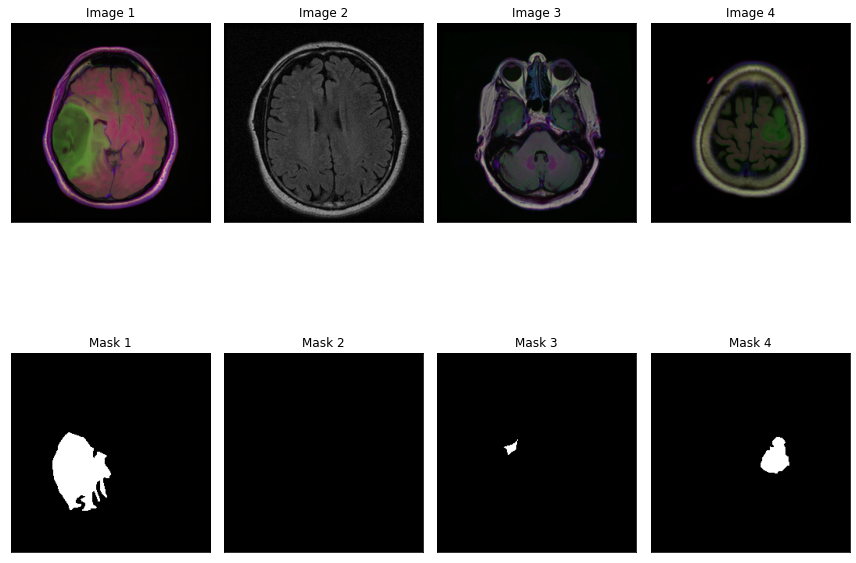

In [ ]:
# plot some random samples
def plot_data(data_paths, mask_paths):
    fig, ax = plt.subplots(2, 4, figsize=(12, 12));
    for i in range(4):
        index = randint(0, len(data_paths)-1)
        img = imread(data_paths[index])
        mask = imread(mask_paths[index])
        ax[0][i%4].imshow(img)
        ax[0][i%4].set_title(f'Image {i+1}')
        ax[0][i%4].set_xticks([])
        ax[0][i%4].set_yticks([])
        ax[1][i%4].imshow(mask, cmap='gray')
        ax[1][i%4].set_title(f'Mask {i+1}')
        ax[1][i%4].set_xticks([])
        ax[1][i%4].set_yticks([])
        plt.tight_layout()
        
plot_data(data_paths,mask_paths)

In [ ]:
# create data frames for train, validation and test sets
df = pd.DataFrame(data={"filename": data_paths, 'mask' : mask_paths})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [ ]:
# get insights about the dataframe
df_train.head()

,filename,mask
2261,/content/kaggle_3m/TCGA_FG_5962_20000626/TCGA_...,/content/kaggle_3m/TCGA_FG_5962_20000626/TCGA_...
551,/content/kaggle_3m/TCGA_DU_5855_19951217/TCGA_...,/content/kaggle_3m/TCGA_DU_5855_19951217/TCGA_...
1235,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
1314,/content/kaggle_3m/TCGA_DU_7014_19860618/TCGA_...,/content/kaggle_3m/TCGA_DU_7014_19860618/TCGA_...
369,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...


In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
  
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  
  image_generator = image_datagen.flow_from_dataframe(
      data_frame,
      x_col = "filename",
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  
  mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  train_gen = zip(image_generator, mask_generator)
    
  for (img, mask) in train_gen:
      img, mask = adjust_data(img, mask)
      yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
smooth = 100
def dice_coef_loss(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    intersection=K.sum(y_truef* y_predf)
    return 1-((2* intersection + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)- intersection
    IOU = (intersection + smooth) / (union  + smooth)
    return IOU


# Build and Compile the Network

In [ ]:
U_Net = Unet()

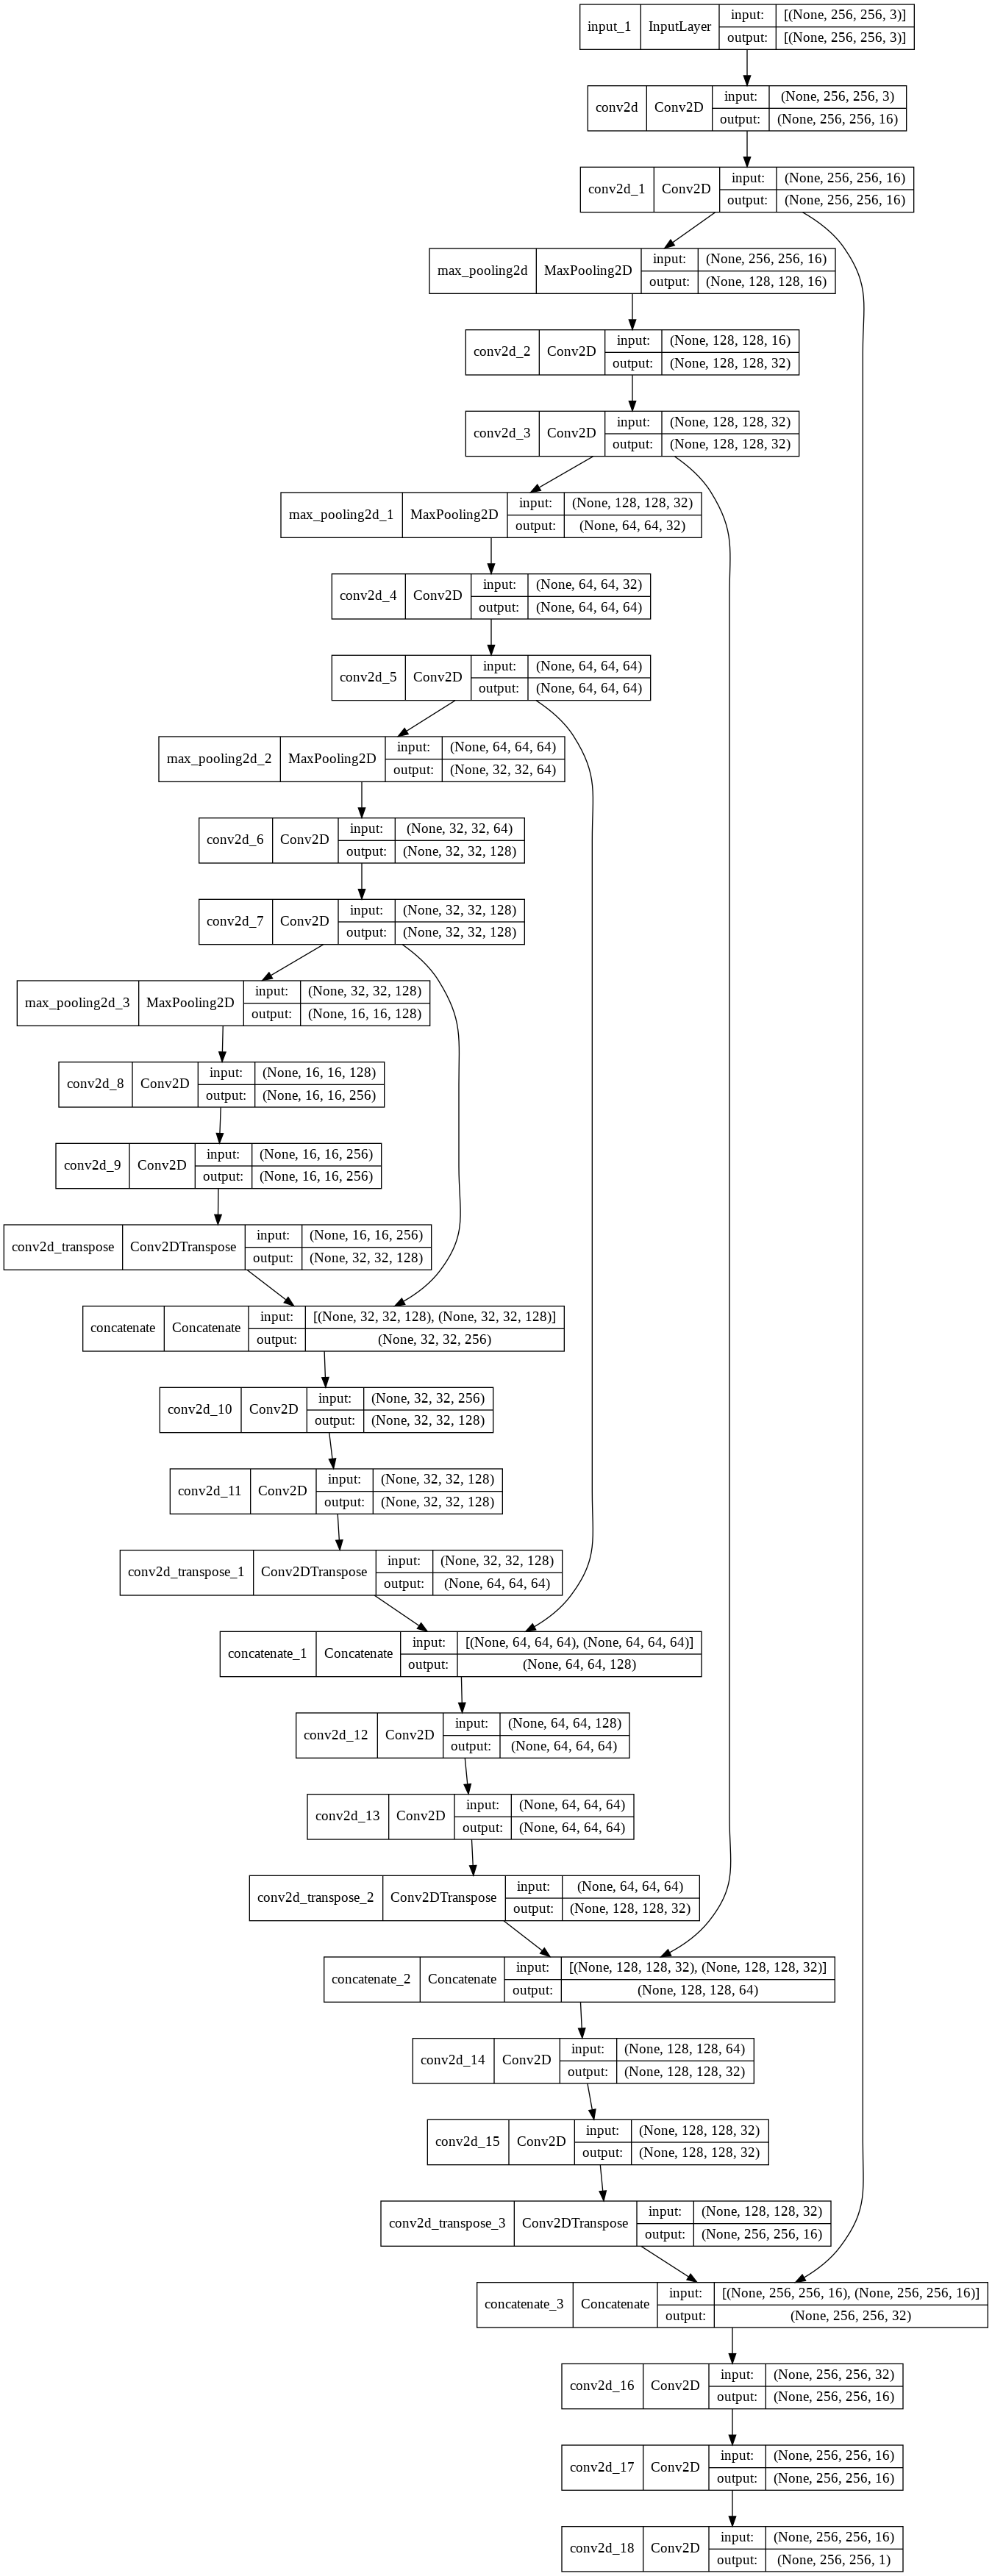

In [ ]:
tf.keras.utils.plot_model(U_Net, show_shapes=True)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, 32,
                                train_generator_args,
                                target_size=(256, 256))

val_gener = train_generator(df_val, 32,
                                dict(),
                                target_size=(256, 256))
    
    

# Train the Network (fit)

In [ ]:
EPOCHS = 100
decay_rate = 1e-4 / EPOCHS
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
U_Net.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou])

callbacks = [tf.keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = U_Net.fit(train_gen,
                    steps_per_epoch=len(df_train) / 32, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gener,
                    validation_steps=len(df_val) / 32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: 0s - loss: 0.9658 - binary_accuracy: 0.4328 - iou: 0.0180Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to 0.90308, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 98s 939ms/step - loss: 0.9658 - binary_accuracy: 0.4328 - iou: 0.0180 - val_loss: 0.9031 - val_binary_accuracy: 0.8457 - val_iou: 0.0528
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: 0.6275 - binary_accuracy: 0.9718 - iou: 0.2496
Epoch 00002: val_loss improved from 0.90308 to 0.42103, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 80s 906ms/step - loss: 0.6275 - binary_accuracy: 0.9718 - iou: 0.2496 - val_loss: 0.4210 - val_binary_accuracy: 0.9920 - val_iou: 0.4083
Epoch 3/100
89/88 [==============================] - ETA: 0s - loss: 0.402

In [ ]:
test_gen = train_generator(df_test, 32,
                                dict(),
                                target_size=(256, 256))
results = U_Net.evaluate(test_gen, steps=len(df_test) / 32)

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 4s 308ms/step - loss: 0.1158 - binary_accuracy: 0.9977 - iou: 0.7930


In [ ]:
U_Net.save('trained.h5')

In [ ]:
for k in history.history:
  print(k)

loss
binary_accuracy
iou
val_loss
val_binary_accuracy
val_iou


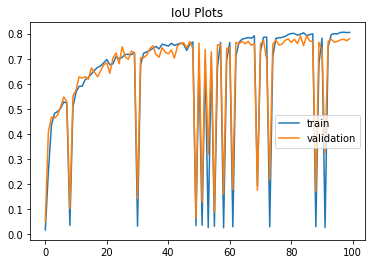

In [ ]:
plt.plot(range(len(history.history['iou'])), history.history['iou'])
plt.plot(range(len(history.history['val_iou'])), history.history['val_iou'])
plt.title('IoU Plots')
plt.legend(['train', 'validation']);

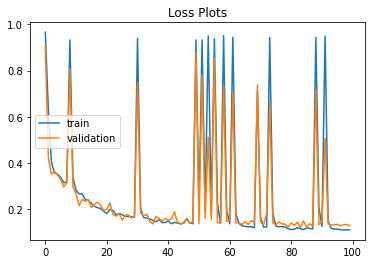

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['loss'])), history.history['val_loss'])
plt.title("Loss Plots")
plt.legend(['train', 'validation']);

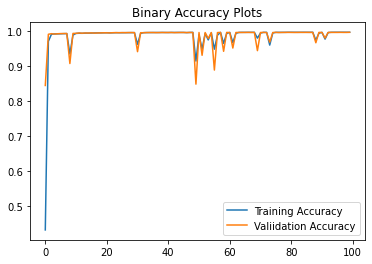

In [ ]:
plt.plot(range(len(history.history['binary_accuracy'])), history.history['binary_accuracy'])
plt.plot(range(len(history.history['val_binary_accuracy'])), history.history['val_binary_accuracy'])
plt.title('Binary Accuracy Plots')
plt.legend(['Training Accuracy', 'Valiidation Accuracy']);


# Plot Some Examples from the Test Set with Actual and Predicted Masks

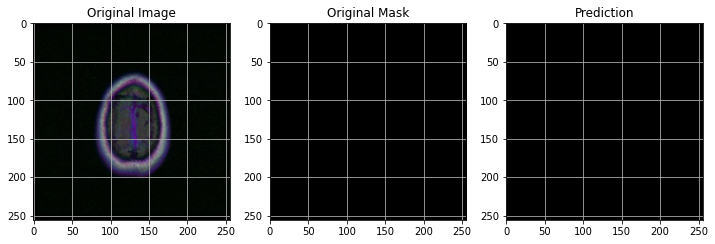

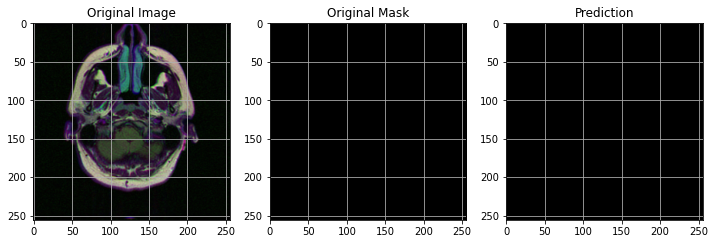

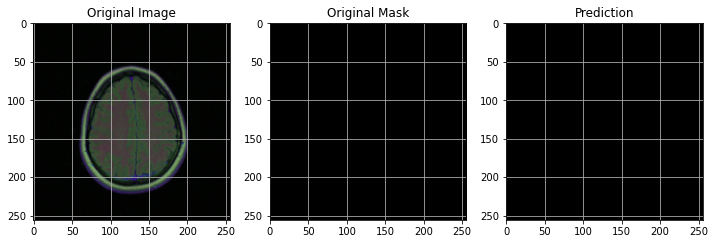

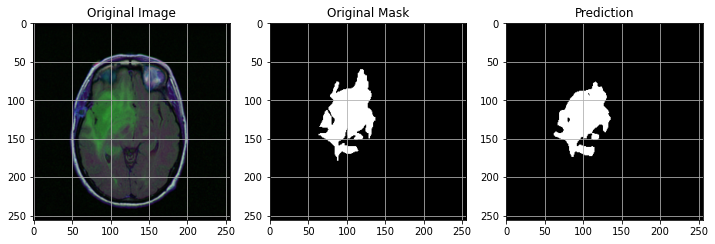

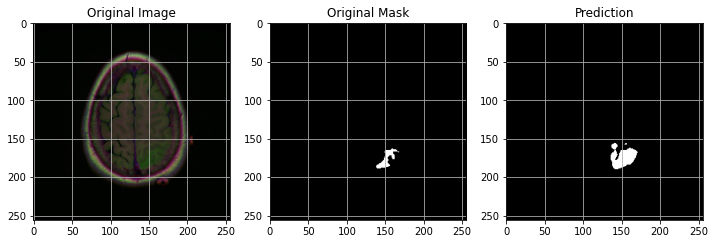

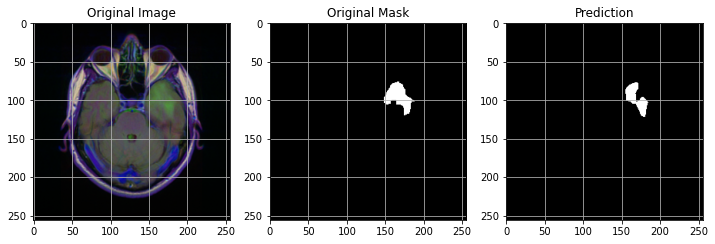

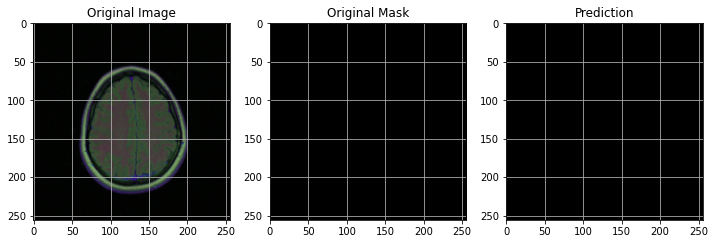

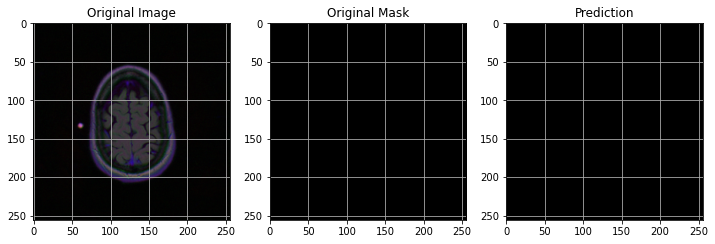

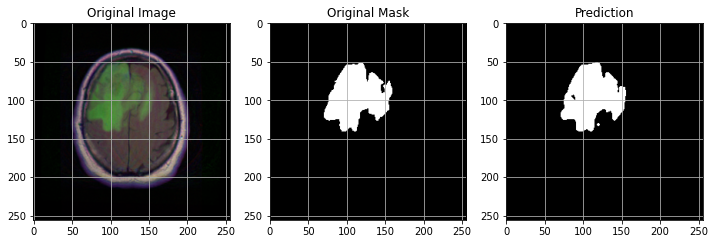

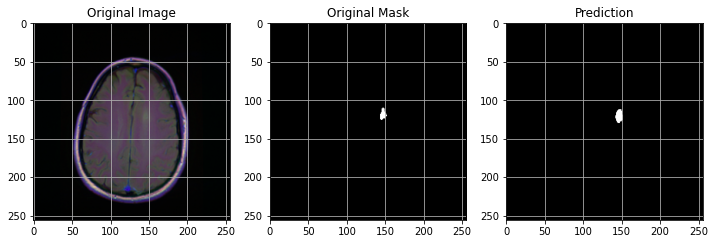

In [ ]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = imread(df_test['filename'].iloc[index])
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=U_Net.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.grid(True)
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(imread(df_test['mask'].iloc[index])), cmap='gray')
    plt.title('Original Mask')
    plt.grid(True)
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5, cmap='gray')
    plt.title('Prediction')
    plt.grid(True)
    plt.show()